Задание: Найти динозавра
1. Выбрать одинаковых динозавров с разных изображений
2. Получить признаки одного изображения с помощью ResNet. (Использовать output с layer4)
3. Получить признаки динозавра с соседнего изображения (использовать output с avgpool)
4. Сравнивая признаки ("косинусное" расстояние) найти динозавра на изображении. Построить тепловую карту

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

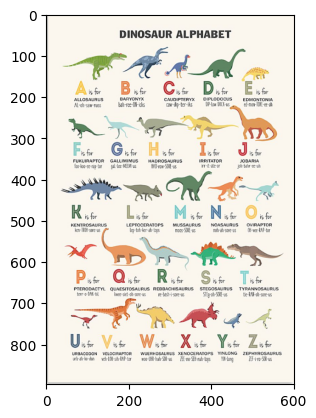

In [2]:
image = cv2.imread('abc.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

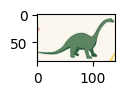

In [3]:
# template = image[680:765, 90:220].copy() # velociraptor
# template = image[75:160, 185:300].copy() # baryonyx
# template = image[550:600, 40:125].copy() # pterodactyl
template = image[75:160, 345:485].copy() # diplodocus
plt.figure(figsize=(1, 1))
plt.imshow(template)
plt.show()

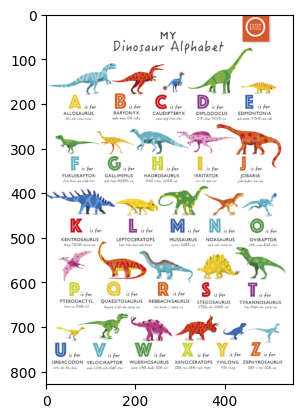

In [4]:
image2 = cv2.imread('A_BC.png')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
plt.imshow(image2)
plt.show()

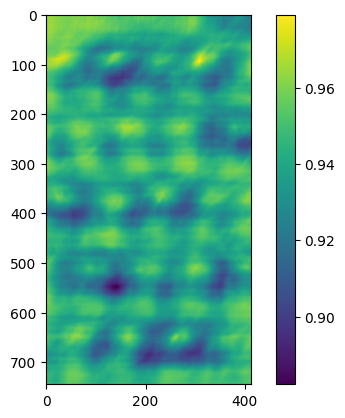

In [5]:
match2 = cv2.matchTemplate(image2, template, cv2.TM_CCORR_NORMED)
plt.imshow(match2)
plt.colorbar()
plt.show()

In [6]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

In [7]:
model = models.resnet18(pretrained=True)
layer4_features = None
avgpool_emb = None

def get_features(module, inputs, output):
    global layer4_features
    layer4_features = output

def get_embedding(module, inputs, output):
    global avgpool_emb
    avgpool_emb = output

model.layer4.register_forward_hook(get_features)
model.avgpool.register_forward_hook(get_embedding)
model.eval()

print (image.shape)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]


(897, 601, 3)


In [8]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

In [9]:
def new_heatmap(model,source,target):
    # [x, y, 3] -> [3, x, y]
    source_tensor = preprocess(source)
    target_tensor = preprocess(target)

    model(source_tensor[None,:,:,:])
    matrixes = layer4_features # [1, 512, x, y]

    model(target_tensor[None,:,:,:])
    vector = avgpool_emb

    product = matrixes * vector # elementwise multiplication

    heatmap = product.sum(dim=1) / (matrixes.sum(dim=1) * vector.sum(dim=1)) # M*v / |M|*|v| = cos(a)
    heatmap = (heatmap - heatmap.min()).max() - (heatmap - heatmap.min()) # normalize: calcuate difference with min and max elements
    heatmap = (heatmap / heatmap.max() * 255).byte()
    heatmap = heatmap.squeeze().detach().numpy()

    heatmap = cv2.resize(heatmap, (source.shape[1], source.shape[0]))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    res = cv2.addWeighted(source, 0.5, heatmap, 0.5, 0)

    return res

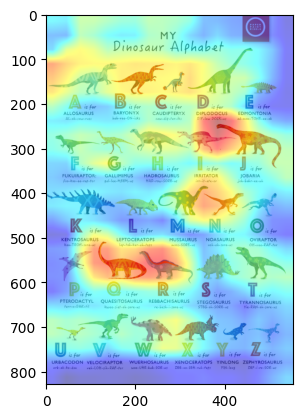

In [10]:
plt.imshow(new_heatmap(model, image2, template))